In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import funciones_hidrologicas as fh
import seaborn as sns
import os

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Lectura de datos csv
df = pd.read_csv('Precipitaci_n_20241116.csv',
                index_col='FechaObservacion',)

estaciones = df['CodigoEstacion'].unique()

dic_dfs = {}

for estacion in estaciones:
    df_estacion = df[df['CodigoEstacion'] == estacion]
    df_estacion.index = pd.to_datetime(df_estacion.index)
    df_estacion = df_estacion.sort_index()

    df_estacion.to_csv(f'{estacion}.csv')

# Analisis de consistencia de los datos
Para ello se busca extraer de cadad csv el numero de datos faltantes y la longitud temporal de los datos

In [5]:
def files(path):
    archivos = os.listdir(path)
    archivos_leer = [os.path.join(path,archivo) for archivo in archivos]

    return archivos_leer

In [ ]:
archivos = files(r'G:\Mi unidad\HME\codigo\datos')


In [4]:
# Extraccion de informacion y arreglo de datos
path_guardado = r'G:\Mi unidad\HME\codigo\vectores_lluvia'
dic_datos = {}
for archivo in archivos:

    # Donde se almacenan los datos de cada dataframe
    datos = []
    # Se lee el dataframe
    df = pd.read_csv(archivo,index_col='FechaObservacion')
    # Arreglo de datos en formato datetime
    df.index = pd.to_datetime(df.index) 
    # Se extrae el codigo 
    cod = df['CodigoEstacion'].unique()[0]
    datos.append(df['CodigoEstacion'].unique()[0])
    datos.append(df['ZonaHidrografica'].unique()[0])
    datos.append(df['Latitud'].unique()[0])
    datos.append(df['Longitud'].unique()[0])
    # Se almacenan los datos en el diccionario
    dic_datos[cod] = datos
    # Extraccion de datos en vector
    df_vector = df[['ValorObservado']]

    nombre = archivo.split('\\')[-1]
    nombre_archivo = os.path.join(path_guardado,nombre)

    df_vector.to_csv(nombre_archivo)

NameError: name 'archivos' is not defined

In [3]:
def llenar_na(df,freq):
    # Seleccion de fechas
    fecha_inicio = df.index[0]
    fecha_final = df.index[-1]
    # Generacion lista con fecha
    rango_fechas = pd.date_range(fecha_inicio,fecha_final,freq=freq)
    # re-index de datos 
    df = df.reindex(rango_fechas)

    return df

In [95]:
path = r'G:\Mi unidad\HME\codigo\vectores_lluvia'
vectores = files(path)

In [115]:
faltantes = {}
for vector in vectores:

    # Crea lista vacia
    datos = []
    df = pd.read_csv(vector,index_col='FechaObservacion')
    df.index = pd.to_datetime(df.index)
    df1 = df[~df.index.duplicated(keep='first')]
    # Se rellenan los espacios vacios con NAN
    df_lleno = llenar_na(df1,'10min')
    # Se extrae la fecha inicial y final
    fecha_inicial = df.index[0]
    fecha_final = df.index[-1]
    num_faltantes = df_lleno.isna().sum().values[0]
    pctg_faltantes = np.around(num_faltantes/len(df_lleno),2)
    # Almacenamiento datos
    datos.append(fecha_inicial)
    datos.append(fecha_final)
    datos.append(pctg_faltantes )
    datos.append(len(df_lleno))
    nombre = vector.split('\\')[-1].split('.')[0]
    faltantes[nombre] = datos



In [15]:
## Generacion del algoritmo de extraccion de tormentas
path = r'G:\Mi unidad\HME\codigo\vectores_lluvia\27015290.csv'
df_prueba = pd.read_csv(path,index_col='FechaObservacion')
df_prueba.index = pd.to_datetime(df_prueba.index)

In [18]:
df_prueba.columns[0]

'ValorObservado'

## Funcion de extraccion de tormentas

In [18]:
def tormentas(df:pd.DataFrame, mit:int)->pd.DataFrame:

    # Importante: El dataframe debe ser solo el indice en formato datetime
    # y el valor de la precipitacion.
    # El codigo te regresa el dataframe inicial 
    # Con una columna nueva con un identificador numerico, que identifica el evento de precipitacion.

    # Identifica la columna que contiene laprecipitacion = df.columns[0]
    precipitacion = df.columns[0]
    # Definir el umbral de tiempo (número de ceros consecutivos que delimitan tormentas)
    # se divide por 15 dado que es el diferencial de tiempo de epm
    # Se debe programar mejor para que tome cualquier evento
    umbral_ceros = mit/15

    # Inicializar variables
    evento_id = 0
    en_evento = False
    eventos = []

    # Iterar sobre la serie de tiempo
    for i, lluvia in enumerate(df[precipitacion]):
        if lluvia > 0:
            if not en_evento:  # Iniciar un nuevo evento
                evento_id += 1
                en_evento = True
            eventos.append(evento_id)  # Asignar el evento actual
        else:
            # Verificar si hay suficientes ceros consecutivos después de un valor > 0
            conteo_ceros = 1
            for j in range(i + 1, len(df[precipitacion])):
                if df[precipitacion].iloc[j] == 0:
                    conteo_ceros += 1
                else:
                    break
            # Si los ceros consecutivos superan el umbral, terminar el evento
            if conteo_ceros >= umbral_ceros:
                en_evento = False
            eventos.append(evento_id if en_evento else 0)

    df['Evento'] = eventos

    # Mostrar el DataFrame con eventos identificados
    return df


In [5]:
path = r'G:\Mi unidad\HME\codigo\datos_epm'
archivos = files(path)

In [ ]:
path_guardado = r'G:\Mi unidad\HME\codigo\datos_epm_csv'
for archivo in archivos:

    # Columnas encontradas en el archivo
    column_names = ['ID', 'variable', 'fecha', 'Time', 'valor', 'calidad']

    # Se lee el dataframe
    df = pd.read_csv(archivo, sep='\s+', header=None, 
                     names=column_names,
                     dtype={'Time': str})

    # Arreglo de la fecha
    df['fecha'] = [str(x) for x in df['fecha']]
    df['Fecha'] = df['fecha'] + ' ' + df['Time']
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df.drop(columns=['fecha'],axis=1,inplace=True)

    nombre = archivo.split('\\')[-1].split('.')[0]
    nombre_guardado = os.path.join(path_guardado,nombre+'.csv')

    df.to_csv(nombre_guardado)


# Análisis Exploratorio de los datos
En este apartado se busca revisar el estado de las series para ello se proponen los siguientes puntos:
- Revisión de consistencia y continuidad número de faltantes
- Asignación de fases RMM y ONI a cada serie (lista)
- Ciclos anuales de las estaciones por fases ENSO 
- Series de tiempo diarias por fase ENSO y fase RMM

## Asignacion fases RMM y ONI

In [6]:
path = r'G:\Mi unidad\HME\codigo\datos_epm_csv'
archivos_epm = files(path)

In [7]:
# Lectura de datos del rmm
rmm = pd.read_csv('indice_rmm.csv',
                  usecols=['fecha','phase','amplitude'],
                  index_col='fecha',
                  parse_dates=['fecha'])

In [8]:
# Lectura datos ONI
df_oni = pd.read_csv('oni_final.csv', index_col='Fecha',
                     parse_dates=['Fecha'])
df_oni_rename = df_oni.rename(columns={'ONI':'oni'})

In [9]:
# Clasificación ENSO basada en persistencia de 5 meses
def classify_enso_with_persistence(df):
    df['enso_phase'] = 'neutro'  # Inicializamos con "Neutral"
    for i in range(len(df) - 4):
        # Tomamos una ventana de 5 meses consecutivos
        window = df['oni'].iloc[i:i+5]
        if all(window >= 0.5):
            df.iloc[i:i+4, 1] = 'niño'
        elif all(window <= -0.5):
            df.iloc[i:i+4, 1] = 'niña'
    return df


# Unir los datos diarios con las fases ENSO
def clasificar_enso(df_oni,df_precip):
    df_precip['month'] = df_precip.index.to_period('M')
    df_oni['month'] = df_oni.index.to_period('M')
    df_merged = pd.merge(df_precip, df_oni, on='month', how='left')
    df_merged.index = df_precip.index

    return df_merged[['valor','enso_phase']]

def etiqueta_quinceminutal(df_quince,df_diario):
        
    df_quince['enso_phase'] = df_quince.index.normalize().map(df_diario['enso_phase'])
    df_quince['phase'] = df_quince.index.normalize().map(df_diario['phase'])
    df_quince['amplitude'] = df_quince.index.normalize().map(df_diario['amplitude'])

    return df_quince

def clasificacion_rmm(df_rmm,df_pptn):

    # Seleccion de fechas del dataframe
    fechas = df_pptn.index
    # se filtran los datos del rmm con las fechas
    # del dataframe de precipitacion
    fase_amplitud = df_rmm[df_rmm.index.isin(fechas)]
    # Se unen los dataframes
    df_merge = pd.concat([df_pptn,fase_amplitud],axis=1)

    return df_merge


In [73]:
# Clasifica el ENSO
df_oni_class = classify_enso_with_persistence(df_oni_rename)
path_guardado = r'G:\Mi unidad\HME\codigo\datos_epm_etiquetados'

for idx,archivo in enumerate(archivos_epm):

    # Lectura de datos
    df_epm = pd.read_csv(archivo,
                        index_col='Fecha',
                        parse_dates=['Fecha'],
                        usecols=['valor','Fecha'])
    # Resample de datos
    df_epm_res = df_epm.resample('D').sum()
    # Etiqueta los datos con el ENSO
    df_epm_enso = clasificar_enso(df_oni_class,df_epm_res)
    #Clasificacion RMM en dataframe proveniente del ENSO
    df_epm_rmm = clasificacion_rmm(rmm,df_epm_enso)
    # Etiquetado quinceminutal
    df_epm_etiquetado = etiqueta_quinceminutal(df_epm,df_epm_rmm)
    # Se guardan los datos
    nombre = archivo.split('\\')[-1]
    nombre_guardado = os.path.join(path_guardado,nombre)
    df_epm_etiquetado.to_csv(nombre_guardado)

## Figuras
Se generan figuras del ciclo anual, ciclo diurno y serie de tiempo

In [101]:
def ciclo_anual_plot(df_epm_etiquetado:pd.DataFrame,
                     estacion:str,
                     path_guardado):
    
    # Selecciona las fases del ENSO
    nina = df_epm_etiquetado[df_epm_etiquetado['enso_phase']=='niña']
    nino = df_epm_etiquetado[df_epm_etiquetado['enso_phase']=='niño']
    neutro = df_epm_etiquetado[df_epm_etiquetado['enso_phase']=='neutro']

    ## Estima el Ciclo anual por fase ENSO
    plt.figure(figsize=(12, 6))
    nina_ciclo_anual = fh.ciclo_anual(nina[['valor']],
                                      umbral=0.1,
                                      freq='15min')
    nino_ciclo_anual = fh.ciclo_anual(nino[['valor']],
                                      umbral=0.1,
                                      freq='15min')
    neutro_ciclo_anual = fh.ciclo_anual(neutro[['valor']],
                                        umbral=0.1,
                                        freq='15min')

    meses = ["Ene", "Feb", 
             "Mar", "Abr", 
             "May", "Jun", 
             "Jul", "Ago", 
             "Sep", "Oct", 
             "Nov", "Dic"]
    
    # Genera los grafico
    plt.plot(nina_ciclo_anual,label='Niña',color='Blue')
    plt.plot(nino_ciclo_anual,label='Niño',color='red')
    plt.plot(neutro_ciclo_anual,label='Neutro',color='grey')
    plt.title(f'Ciclo anual estación {estacion}',
              fontsize=16, fontweight="bold")
    plt.ylabel('Precipitación[mm]',fontsize=14)

    plt.xticks(ticks=range(1, 13), 
               labels=meses,
               fontsize=12)
    plt.grid()
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(path_guardado)
    plt.close()

In [42]:
path = r'G:\Mi unidad\HME\codigo\datos_epm_etiquetados'
archivos_epm = files(path)

In [102]:
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\ciclo_anual'
for archivo in archivos_epm:
    nombre = archivo.split('\\')[-1].split('.')[0]

    df_epm = pd.read_csv(archivo,
                        index_col='Fecha',
                        parse_dates=['Fecha'],)
    
    nombre_figura = nombre + '.png'
    nombre_guardado = os.path.join(path_guardado,
                                   nombre_figura)
    
    ciclo_anual_plot(df_epm,
                     nombre,
                     nombre_guardado)

In [10]:
def serie_tiempo_rmm(df_epm_etiquetado:pd.DataFrame,
                     estacion:str,
                     path_guardado):
    
    # Arreglo de datos
    df_epm_diario = df_epm_etiquetado.resample('D').sum()
    df_etiquetado = clasificacion_rmm(rmm,df_epm_diario)
    df_inactivo = df_etiquetado[df_etiquetado['amplitude']<1.0]
    df_activo = df_etiquetado[df_etiquetado['amplitude']>=1.0]

    plt.figure(figsize=(14, 7))

    for i in range(9):


        # Fase inactiva
        if i == 0:
            df_pptn_epm = llenar_na(df_inactivo,'D')

        else:
            df_activo = df_etiquetado[(df_etiquetado['amplitude']>=1.0) & (df_etiquetado['phase']==i)]
            df_pptn_epm = llenar_na(df_activo,'D')

        plt.plot(df_pptn_epm[['valor']],label=f'Fase {i}')


    # Personalización del gráfico
    plt.title(f"Serie de Tiempo estación {estacion}", 
              fontsize=16, fontweight="bold")

    plt.ylabel("Precipitación[mm]", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Fases MJO", 
               fontsize=12, title_fontsize=14, 
               loc="upper right", ncol=2)

    plt.grid(alpha=0.5, linestyle="--", color='black')
    plt.tight_layout()
    plt.savefig(path_guardado)
    plt.close()


In [48]:
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\serie_tiempo_rmm'

for archivo in archivos_epm:
    nombre = archivo.split('\\')[-1].split('.')[0]

    df_epm = pd.read_csv(archivo,
                        usecols=['Fecha','valor'],
                        index_col='Fecha',
                        parse_dates=['Fecha'],)
    
    nombre_figura = nombre + '.png'
    nombre_guardado = os.path.join(path_guardado,
                                   nombre_figura)
    
    serie_tiempo_rmm(df_epm,
                     nombre,
                     nombre_guardado)

In [14]:
df_epm = pd.read_csv(archivos_epm[0],
                        usecols=['Fecha','valor'],
                        index_col='Fecha',
                        parse_dates=['Fecha'],)

In [59]:
## Revision de datos faltantes
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\serie_tiempo'
for file in archivos_epm:
    df = pd.read_csv(file,
               usecols=['Fecha','valor'],
               index_col='Fecha',
               parse_dates=['Fecha'],)
    
    df_epm_diario = df.resample('D').sum()
    
    nombre = file.split('\\')[-1].split('.')[0]
    nombre_figura = nombre + '.png'
    nombre_guardado = os.path.join(path_guardado,
                                    nombre_figura)
    

    plt.figure(figsize=(14, 7))

    plt.plot(df_epm_diario,
             color='blue')
    # Personalización del gráfico
    plt.title(f"Serie de Tiempo estación {nombre}", 
              fontsize=16, fontweight="bold")

    plt.ylabel("Precipitación[mm]", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    plt.grid(alpha=0.5, linestyle="--", color='black')
    plt.tight_layout()
    plt.savefig(nombre_guardado)
    plt.close()

In [11]:
def serie_tiempo_enso(df_etiquetado:pd.DataFrame,
                     estacion:str,
                     path_guardado):
    
    df_nino = llenar_na(df_etiquetado[df_etiquetado['enso_phase'] == 'niño'],freq='D')
    df_nina = llenar_na(df_etiquetado[df_etiquetado['enso_phase'] == 'niña'],freq='D')
    df_neutro = llenar_na(df_etiquetado[df_etiquetado['enso_phase'] == 'neutro'],freq='D')

    plt.figure(figsize=(14, 7))


    plt.plot(df_nino[['valor']],
             label=f'Niño',color ='red')
    plt.plot(df_nina[['valor']],
             label=f'Niña',color ='blue')
    plt.plot(df_neutro[['valor']],
             label=f'Neutro',color='grey')



    # Personalización del gráfico
    plt.title(f"Serie de Tiempo estación {estacion}", 
              fontsize=16, fontweight="bold")

    plt.ylabel("Precipitación[mm]", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Fases ENSO", 
               fontsize=12, title_fontsize=14, 
               loc="upper right", ncol=1)

    plt.grid(alpha=0.5, linestyle="--", color='black')
    plt.tight_layout()
    plt.savefig(path_guardado)
    plt.close()

In [84]:
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\serie_tiempo_oni'
df_oni_class = classify_enso_with_persistence(df_oni_rename)
for archivo in archivos_epm:
    nombre = archivo.split('\\')[-1].split('.')[0]

    df_epm = pd.read_csv(archivo,
                        usecols=['Fecha','valor'],
                        index_col='Fecha',
                        parse_dates=['Fecha'],)
    
    df_epm_diario = df_epm.resample('D').sum()
    df_etiquetado = clasificar_enso(df_oni_class ,df_epm_diario)

    nombre_figura = nombre + '.png'
    nombre_guardado = os.path.join(path_guardado,
                                   nombre_figura)
    
    serie_tiempo_enso(df_etiquetado,
                     nombre,
                     nombre_guardado)

### Analisis de consitencia de los datos
Se corren test de homogeneidad y tendencias sobre los datos para mirar su comportamiento y calidad

In [12]:
import homogeneidad as hm

In [13]:
## Figuras homogeneidad
def plot_pettit(df:pd.DataFrame,
                resultados_pettit:tuple,
                nombre:str,
                path_guardado:str):

    df_res = df.resample('YE').sum()
    # Se eliminan anualidades con valores 0
    df_res = df_res[df_res['valor']>0]
    min_valor = df_res['valor'].min()

    mn = df_res.index[0]
    mx = df_res.index[-1]

    change_point = resultados_pettit.cp
    loc = df_res.index[change_point]
    mu1 = resultados_pettit.avg.mu1
    mu2 = resultados_pettit.avg.mu2
    p_value = resultados_pettit.p

    plt.figure(figsize=(14, 7))
    plt.plot(df_res,color='blue')
    plt.hlines(mu1, xmin=mn, xmax=loc, 
               linestyles='--', colors='orange',
               lw=1.5, label='mu1 : ' + str(round(mu1,2)))

    plt.hlines(mu2, xmin=loc, xmax=mx, 
               linestyles='--', colors='g', lw=1.5, 
               label='mu2 : ' + str(round(mu2,2)))

    
    plt.axvline(x=loc, linestyle='-.' , color='red', 
                lw=1.5, label='Change point : '+ loc.strftime('%Y-%m-%d') + '\n p-value : ' + str(p_value))

    plt.ylim(min_valor)
    plt.grid()
    plt.title(f'Estación {nombre}',
              fontsize=16, weight='bold')
    
    plt.xlabel('Años',fontsize=14)
    plt.ylabel('Precipitación[mm]',fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper right',fontsize=13)
    plt.tight_layout()
    plt.savefig(path_guardado)
    plt.close()


In [14]:
# Diccionarios vacios para almacenar los datos
dic_mk: dict = dict()
dic_pettit: dict = dict()
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\figuras_homogeneidad'
# Pruebas de homogeneidad
for archivo in archivos_epm:
    df_epm = pd.read_csv(archivo,
                        usecols=['Fecha','valor'],
                        index_col='Fecha',
                        parse_dates=['Fecha'],)
    # Aplicacion de las pruebas
    resultados_mk = hm.mann_kendall(df_epm,'pptn')
    resultados_pettit = hm.pettit(df_epm,'pptn')
    # Nombre de las estaciones
    nombre = archivo.split('\\')[-1].split('.')[0]

    dic_mk[nombre] = resultados_mk
    dic_pettit[nombre] = resultados_pettit

    # Grafico de datos
    resultados_pettit = dic_pettit[nombre] 
    nombre_figura = nombre + '.png'

    nombre_guardado = os.path.join(path_guardado,
                                    nombre_figura)
    
    plot_pettit(df_epm,
                resultados_pettit,
                nombre,nombre_guardado)

## Extraccion de tormentas
Para la extraccion de tormentas se planea utilizar MIT = [30,60,120,180,360] minutos. Para cada estacion se especifica el MIT utilizado y apartir de ello las identificacion de tormentas,

In [16]:
# Lectura y arreglo de las estaciones a trabajar
path = r'G:\Mi unidad\HME\codigo\datos_epm_csv'
archivos_epm = files(path)

In [20]:
# Loop principal de extraccion e identificacion de tormentas
# Defincion de los mit = 30, 60, 120, 180 y 360 minutos
# se ingresa
mit = [360]
# Carpeta madre donde se almacenan las tormentas
path_guardado = r'G:\Mi unidad\HME\codigo\tormentas'
for archivo in archivos_epm:

    #Extrae el nombre de la estacion
    nombre_estacion = archivo.split('\\')[-1].split('.')[0]
    # Esto con el fin de controlar en que estacion va
    print(nombre_estacion)
    # Se abre el df
    df = pd.read_csv(archivo,
                     index_col='Fecha',
                     usecols=['Fecha','valor'],
                     parse_dates=['Fecha'])
    
    # Se define una lista vacia que almacena
    # los eventos con diferentes MIT 

    dfs_mit = []
    # Ciclo anidado que extrae las tormentas
    for umbral_mit in mit:
        # Esto con el fin de controlar el mit
        print(umbral_mit)
        # Se crea una copia para no sobreescribir el archivo
        df_copia = df.copy()
        # Se extraen las tormenta
        df_tormenta = tormentas(df_copia,umbral_mit)
        # Se guarda el identificador del mit
        df_tormenta['mit'] = umbral_mit
        #Se almacenan los resultados en la lista
        dfs_mit.append(df_tormenta)
    #Concatena las tormentas
    df_tormenta_concat = pd.concat(dfs_mit,axis=0)
    # nombre archivo
    
    nombre_archivo = nombre_estacion + '.csv'
    # creacion de la carpeta nueva
    path_carpeta_nueva = os.path.join(path_guardado, nombre_estacion)
    os.makedirs(path_carpeta_nueva)
    # ruta almacenamiento archivo
    path_csv_tormenta = os.path.join(path_carpeta_nueva,nombre_archivo)
    #Almacenamiento de datos:
    df_tormenta_concat.to_csv(path_csv_tormenta)
    print(f'guardado completo estacion {nombre_estacion}')

Vasconia
360
guardado completo estacion Vasconia
Villa Hermosa
360
guardado completo estacion Villa Hermosa
Santa Barbara
360
guardado completo estacion Santa Barbara
San Pedro
360
guardado completo estacion San Pedro
San Bernardo
360
guardado completo estacion San Bernardo
San Cristobal
360
guardado completo estacion San Cristobal
Pabon
360
guardado completo estacion Pabon
Rionegro La Macarena
360
guardado completo estacion Rionegro La Macarena
San Antonio de Prado
360
guardado completo estacion San Antonio de Prado
Montañitas
360
guardado completo estacion Montañitas
Miraflores
360
guardado completo estacion Miraflores
Medina
360
guardado completo estacion Medina
Mesopotamia
360
guardado completo estacion Mesopotamia
Mazo
360
guardado completo estacion Mazo
La Teresita
360
guardado completo estacion La Teresita
La Severa
360
guardado completo estacion La Severa
Las Palmas
360
guardado completo estacion Las Palmas
La Palmera
360
guardado completo estacion La Palmera
La Pladera
360
gua

## Analisis de resultados 
se extraen las variables descriptoras de los eventos de tormenta

In [4]:
def variables_tormenta(df:pd.DataFrame, path:str) -> pd.DataFrame:

    eventos = df['Evento'].unique()
    # Se elimnan los eventos 0
    mask = eventos != 0
    eventos_limpios = eventos[mask]

    #Dataframe de almacenamiento de datos
    df_vars = dict()
    for evento in eventos_limpios:

        df_evento = df[df['Evento'] == evento]

        # Se desechan eventos 
        # con con un solo dato
        if len(df_evento) <= 1:
            continue
        # Crea la llave para el evento
        df_vars[evento] = []

        # Fecha cuando inicial el evento
        fecha_evento = df_evento.index[0]
        fecha_siguiente = df_evento.index[1]
        fecha_final = df_evento.index[-1]

        # Duracion
        duracion = fecha_final - fecha_evento
        duracion_evento = duracion.total_seconds()/60
        #delta t
        delta = fecha_siguiente - fecha_evento
        delta_t = delta.total_seconds()/60
        # Precipitacion acumulada/ Intensidad media
        pptn_acumulada = df_evento['valor'].sum()
        intensidad_media = pptn_acumulada/duracion_evento
        # Intensidad maxima
        df_evento = df_evento.copy()
        df_evento.loc[:,'pptn_acum'] = df_evento['valor'].cumsum()
        df_evento.loc[:,'intensidad'] = df_evento['pptn_acum'].diff()/delta_t
        i_max = df_evento['intensidad'].max()

        # Almacenamiento de variables
        df_vars[evento].append(fecha_evento)
        df_vars[evento].append(duracion_evento)
        df_vars[evento].append(pptn_acumulada)
        df_vars[evento].append(intensidad_media)
        df_vars[evento].append(i_max)

    columnas = ['fecha_evento','duracion','pptn_acumulada',
                'intensidad_media','intensidad_maxima']

    df_variables = pd.DataFrame(df_vars,index = columnas).T

    # Guardado de resultados

    df_variables.to_csv(path)

In [59]:
fecha_evento = pd.to_datetime('1991-01-01 15:00')
fecha_siguiente = pd.to_datetime('1991-01-01 15:00')
fecha_final = pd.to_datetime('1991-01-01 15:15')
# Duracion
duracion = fecha_final - fecha_evento
duracion_evento = duracion.total_seconds()/60

In [5]:
path_carpeta_ppal = r'G:\Mi unidad\HME\codigo\tormentas'
estaciones = files(path_carpeta_ppal)

In [24]:
# Extracciones de variables descriptoras
path_guardado_estacion = r'G:\Mi unidad\HME\codigo\vars_descriptoras'
for path_estacion in estaciones:
    
    #Lectura de datos
    archivo = files(path_estacion)[0]

    df = pd.read_csv(archivo, usecols = ['Fecha','valor','Evento'],
                                        index_col='Fecha',
                                        parse_dates=['Fecha'])
    
    # path de guardado de los datos
    nombre_estacion = path_estacion.split('\\')[-1]
    nombre_gaurdado = f'vars_descriptoras_{nombre_estacion}.csv'
    path_guardado = os.path.join(path_guardado_estacion, nombre_gaurdado)

    # Extraccion de tormentas
    print(f'Guardando estación {nombre_estacion}...')
    variables_tormenta(df,path_guardado)

    
    

Guardando estación Vasconia...
Guardando estación Villa Hermosa...
Guardando estación Santa Barbara...
Guardando estación San Pedro...
Guardando estación San Bernardo...
Guardando estación San Cristobal...
Guardando estación Pabon...
Guardando estación Rionegro La Macarena...
Guardando estación San Antonio de Prado...
Guardando estación Montañitas...
Guardando estación Miraflores...
Guardando estación Medina...
Guardando estación Mesopotamia...
Guardando estación Mazo...
Guardando estación La Teresita...
Guardando estación La Severa...
Guardando estación Las Palmas...
Guardando estación La Palmera...
Guardando estación La Pladera...
Guardando estación Haiton...
Guardando estación La Mosca...
Guardando estación El Pital...
Guardando estación Fabricato...
Guardando estación El Sireno...
Guardando estación El Mango...
Guardando estación El Gomez...
Guardando estación El Chaquiro...
Guardando estación El Bizcocho...
Guardando estación Corrientes...
Guardando estación Caldas...
Guardando es

In [12]:
path_etiquetados = r'G:\Mi unidad\HME\codigo\datos_epm_etiquetados'
path_variables = r'G:\Mi unidad\HME\codigo\vars_descriptoras'
path_guardado = r'G:\Mi unidad\HME\codigo\vars_descriptoras_etiquetadas'
files_etiquetados = files(path_etiquetados)

for file_etiquetado in files_etiquetados:

    nombre = file_etiquetado.split('\\')[-1]
    nombre_archivo_vars = f'vars_descriptoras_{nombre}'
    path_archivo_var = os.path.join(path_variables, nombre_archivo_vars)

    # Lectura de dataframes
    df_var = pd.read_csv(path_archivo_var,
                         index_col='fecha_evento',
                     parse_dates=['fecha_evento'])

    df_etiqueta = pd.read_csv(file_etiquetado,
                              index_col='Fecha',
                              parse_dates=['Fecha'])
    
    # Mascara con la cual se filtra el dataframe de etiquetas
    mascara = df_etiqueta.index.isin(df_var.index)
    df_filtrado = df_etiqueta[mascara]
    # Solo se mantienen las columnas de etiquetas
    df_slice = df_filtrado.iloc[:,1:]
    # Se unen los dataframes
    df_concat = df_var.merge(df_slice, left_index=True,
                            right_index=True, how="outer")

    # Nombres de los archivos
    nombre_guardado = f'vars_etiquetas_{nombre}.csv'
    path_guardado_estacion = os.path.join(path_guardado,
                                          nombre_guardado)
    
    print(f'Guardando {nombre}...')
    df_concat.to_csv(path_guardado_estacion)

Guardando Vasconia.csv...
Guardando Villa Hermosa.csv...
Guardando Santa Barbara.csv...
Guardando San Pedro.csv...
Guardando San Bernardo.csv...
Guardando San Cristobal.csv...
Guardando Pabon.csv...
Guardando Rionegro La Macarena.csv...
Guardando San Antonio de Prado.csv...
Guardando Montañitas.csv...
Guardando Miraflores.csv...
Guardando Medina.csv...
Guardando Mesopotamia.csv...
Guardando Mazo.csv...
Guardando La Teresita.csv...
Guardando La Severa.csv...
Guardando Las Palmas.csv...
Guardando La Palmera.csv...
Guardando La Pladera.csv...
Guardando Haiton.csv...
Guardando La Mosca.csv...
Guardando El Pital.csv...
Guardando Fabricato.csv...
Guardando El Sireno.csv...
Guardando El Mango.csv...
Guardando El Gomez.csv...
Guardando El Chaquiro.csv...
Guardando El Bizcocho.csv...
Guardando Corrientes.csv...
Guardando Caldas.csv...
Guardando Chorrillos.csv...
Guardando Ayura.csv...
Guardando Aragon.csv...
Guardando Alto San Andres.csv...


### Analisis de los datos etiquetados 

In [6]:
import analisis_tormentas as at
path_vars_etiquetadas = r'G:\Mi unidad\HME\codigo\vars_descriptoras_etiquetadas'
archivos_analisis = files(path_vars_etiquetadas)

In [7]:
dic_variables = {'pptn_acumulada':'Precipitación acumumulada (mm)',
                'intensidad_media':'Intensidad media (mm/min)',
                'intensidad_maxima':'Máxima intensidad (mm/min)',}


In [8]:
import re
def nombre_estacion(path:str) -> str:
    # Expresión regular mejorada
    match = re.search(r'_([^_]+)\.csv(?=\.[^.]*$)', path)
    nombre = match.group(1)

    return nombre


In [9]:
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\relaciones_potenciales'

for archivo_analisis in archivos_analisis:

    df_analisis = pd.read_csv(archivo_analisis,
                              index_col='fecha_evento',
                              parse_dates=['fecha_evento'])
    
    # Se filtran los eventos para mantener 
    # aquellos con pptn acumulada > 10.0

    umbral_pptn = 10.0
    df_filtrado = df_analisis[df_analisis['pptn_acumulada']>umbral_pptn].copy()
    
    #Extrae el nombre de la estacion
    estacion = nombre_estacion(archivo_analisis)

    for var, label_var in dic_variables.items():
        nombre_guardado = f'{estacion}.png'
        path_almacenamiento = os.path.join(path_guardado,var,
                                           nombre_guardado)
        # Se inicia la clase
        analisis_tormentas = at.tormenta(df_filtrado,estacion,'')

        # Se generan figuras
        analisis_tormentas.plots(var,label_var,
                                 path_almacenamiento)



In [7]:
df_prueba = pd.read_csv(archivos_analisis[0],
                        index_col='fecha_evento',
                        parse_dates=['fecha_evento'])

In [8]:
df_filtro = df_prueba[df_prueba['pptn_acumulada']>=10.0]
tormenta = at.tormenta(df_filtro,'','')
nino, nina, neutro = tormenta.intensidad()

In [52]:
# tormenta.plot_intensidad_10()
# tormenta.plot_intensidad_90()
# tormenta.plot_intensidad_10_mjo()

#### Analisis con todas las tormentas

In [16]:
lista_eventos = list()
umbral_pptn = 0
for archivo in archivos_analisis:

    df = pd.read_csv(archivo, index_col=['fecha_evento'], 
                     parse_dates=['fecha_evento'])
    
    df_filtro = df[df['pptn_acumulada']>umbral_pptn]
    lista_eventos.append(df_filtro)

df_eventos = pd.concat(lista_eventos,axis=0)

In [17]:
# Extraccion numero de eventos
pptn_acumulada = [0.1,0.5,1,2,3,5,10,20,30,50,100]
nro_eventos = []

for pptn in pptn_acumulada:

    df = df_eventos[df_eventos['pptn_acumulada']>=pptn]
    nro_eventos.append(len(df))

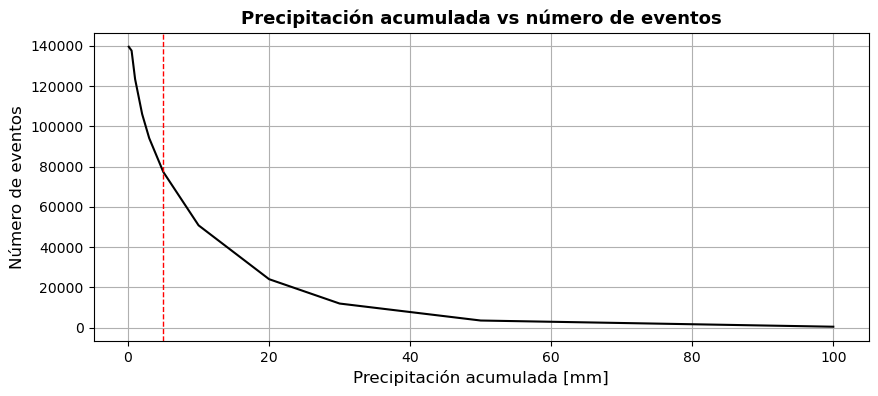

In [36]:
plt.figure(figsize=(10,4))

plt.plot(pptn_acumulada,nro_eventos,color='black',)
plt.title('Precipitación acumulada vs número de eventos',
          fontsize=13,weight='bold')
plt.ylabel('Número de eventos',fontsize=12)
plt.xlabel('Precipitación acumulada [mm]',fontsize=12)
plt.axvline(5,linestyle='--',color='red',linewidth=1)

plt.grid()

In [52]:
np.mean(df_eventos_v1['duracion'])

758.2325662617874

In [37]:
df_eventos_v1 = df_eventos[df_eventos['pptn_acumulada']>=5]

In [38]:
eventos = at.tormenta(df_eventos_v1,'','')

In [99]:
dic_variables = {'pptn_acumulada':'Precipitación acumumulada (mm)',
                'intensidad_media':'Intensidad media (mm/min)',
                'intensidad_maxima':'Máxima intensidad (mm/min)',}
path_guardado = r'G:\Mi unidad\HME\codigo\figuras\presentacion'

for var,y_label in dic_variables.items():
    nombre_guardado = os.path.join(path_guardado,var)
    eventos.plots(var,y_label,nombre_guardado)

g:\Mi unidad\HME\codigo\analisis_tormentas.py:363: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fit,y_fit,color,
g:\Mi unidad\HME\codigo\analisis_tormentas.py:462: SyntaxWarning: invalid escape sequence '\m'
  label=label_ajuste,linestyle='--',alpha=0.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


g:\Mi unidad\HME\codigo\analisis_tormentas.py:360: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Duracion[mm]/($\miu$[mm])',fontsize=13)
g:\Mi unidad\HME\codigo\analisis_tormentas.py:459: SyntaxWarning: invalid escape sequence '\m'
  


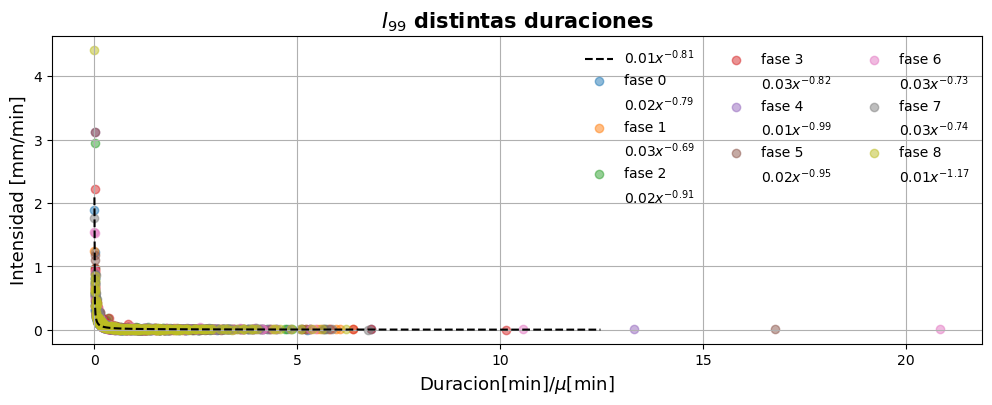

In [83]:
eventos.plot_intensidad_10_mjo()

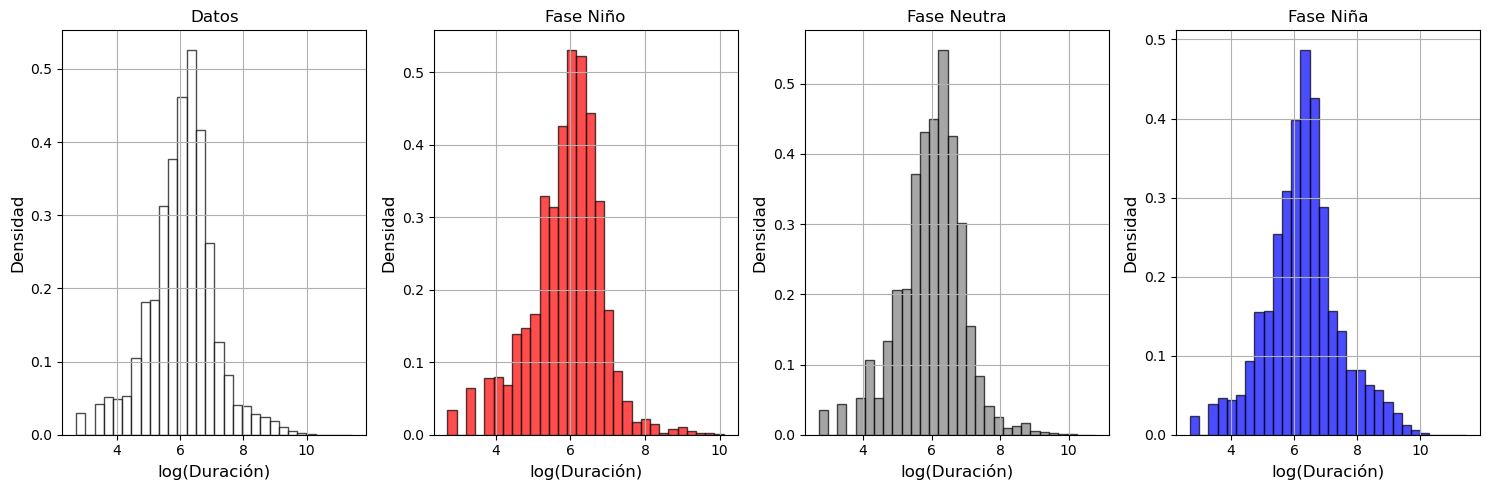

In [103]:
eventos.hist_plot_enso()

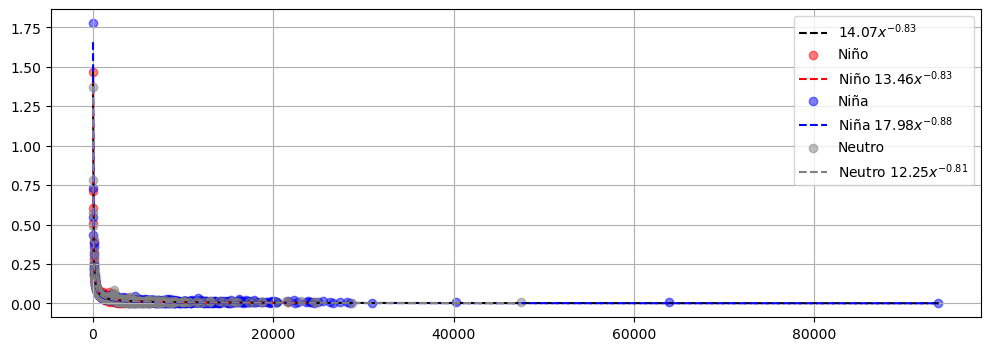

In [11]:
eventos.plot_intensidad_10()

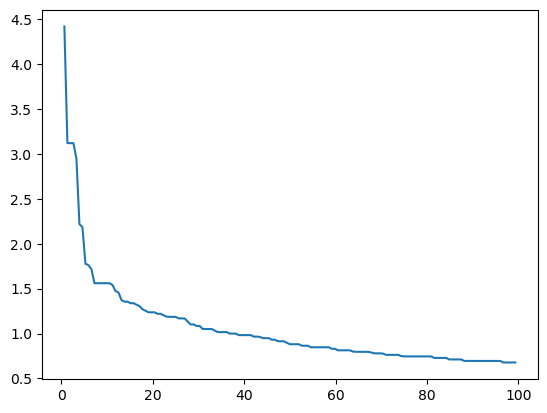

In [17]:
# Crea array con los datos de interes
df = df_eventos[df_eventos['duracion']==15]
var = np.array(df['intensidad_media'])
# Crea dataframe
df_analisis = pd.DataFrame({'variable': var})
# Estimacion excedencia
df_sort = df_analisis.sort_values(by='variable',
                                 ascending=False).reset_index(drop=True)
        
df_sort['Excedencia'] = (df_sort.index + 1)/(len(df_sort) + 1)*100

q_10 = np.interp(10, df_sort['Excedencia'], df_sort['variable'])
q_90 = np.interp(90, df_sort['Excedencia'], df_sort['variable'])

plt.plot(df_sort['Excedencia'], df_sort['variable'])


In [101]:
df_eventos.columns

Index(['Unnamed: 0', 'duracion', 'pptn_acumulada', 'intensidad_media',
       'intensidad_maxima', 'enso_phase', 'phase', 'amplitude'],
      dtype='object')

In [135]:
df_log = df_eventos.copy()
df_log['log_duracion'] = np.log(df_log['duracion'])